In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import math
import pandas as pd
import random
from matplotlib import pyplot as plt
import numpy as np
 
from funciones import read_data, calcular_distancia, calcular_matriz_dist, calcular_largo_ruta, graficar_ruta
from instancia import ubis, cap_tpte, info_locales
from instancia import G, color_nodos, color_arcos, ancho_edges
random.seed(42)
np.random.seed(42)

<Figure size 500x500 with 0 Axes>

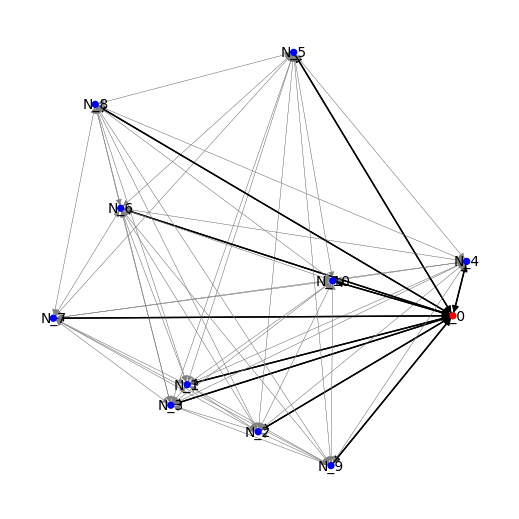

In [2]:
plt.figure(figsize=(5,5))

pos=nx.get_node_attributes(G,'pos')
nx.draw(G, pos=pos, with_labels=True, node_size=18, font_size=10, node_color=color_nodos, width=ancho_edges, edge_color=color_arcos)
plt.show()

In [3]:
matriz_dst = calcular_matriz_dist(G)

In [4]:
def simular_demanda_diaria(data, dist="d",log=False):
    demanda = {}
    demanda[0] = 0
    for i in range(1, len(data)):
        if dist == "p":
            demanda[i] = int(round(np.random.poisson(data[i]),0))
        elif dist == "n":
            demanda[i] = int(round(np.random.normal(data[i], data[i]/10),0))
        elif dist == "u":
            demanda[i] = int(round(np.random.uniform(data[i]/2, data[i]*1.5),0))
        elif dist == "d":

            demanda[i] = int(round(data[i],0))
    
    
    if log:
        print("Demanda del día: ", demanda)
        # print(i, ":", data[i])
    return demanda

dem = simular_demanda_diaria(list(info_locales['r']), dist="d", log=True)


Demanda del día:  {0: 0, 1: 87, 2: 27, 3: 10, 4: 55, 5: 71, 6: 69, 7: 79, 8: 43, 9: 77, 10: 63}


In [5]:
def aplicar_politica_estacionaria(G, info_locales,matriz_dst):
    V = 0
    demanda = simular_demanda_diaria(info_locales['r'][1:],"d")
    for i in range(1,len(info_locales)):
        V += 0
    # Definimos el inventario del día de cada nodo



In [6]:
'''NEAREST NEIGHBOR ALGORITHM FOR VRP'''
def nearest_neighbor(G, dist_matrix, demands, capacity):
    """
    Apply the Nearest Neighbor heuristic to find initial routes for VRP.
    """
    nodos = list(G.nodes)
    N = len(nodos)
    visitados = np.zeros(N, dtype=bool)
    rutas = []

    while np.sum(visitados) < N:
        nodo_actual = 0
        capacidad_actual = 0
        ruta = [nodo_actual]
        visitados[nodo_actual] = True
        while capacidad_actual + demands[nodo_actual] <= capacity:
            actual = f"N_{ruta[-1]}"
            cercano = None
            min_dist = float('inf')
            # print('actual: ', actual)
            for vecino in np.where(~visitados)[0]:
                id_vecino = f"N_{vecino}"
                # print(vecino, id_vecino, actual, dist_matrix[actual][id_vecino], demands[vecino])
                # print(f"vecino: {id_vecino}, distancia: {dist_matrix[actual][id_vecino]} , min_dist: {min_dist}")
                if demands[vecino] + capacidad_actual <= capacity and dist_matrix[actual][id_vecino] < min_dist:
                    cercano = vecino
                    # print('cercano: ', cercano)
                    min_dist = dist_matrix[actual][id_vecino]
            # print(f'Nodo más cercano a {actual}: N_{cercano}')

            if cercano is None:
                break
            else:      
                ruta.append(cercano)
                visitados[cercano] = True
                capacidad_actual += demands[cercano]
        ruta.append(0)
            # print('Ruta actual: ', ruta, '\n')
        print('Ruta actual: ', ruta, '\n')
        rutas.append(ruta)
    return rutas

Ruta actual:  [0, 4, 10, 2, 9, 1, 3, 7, 6, 8, 5, 0] 



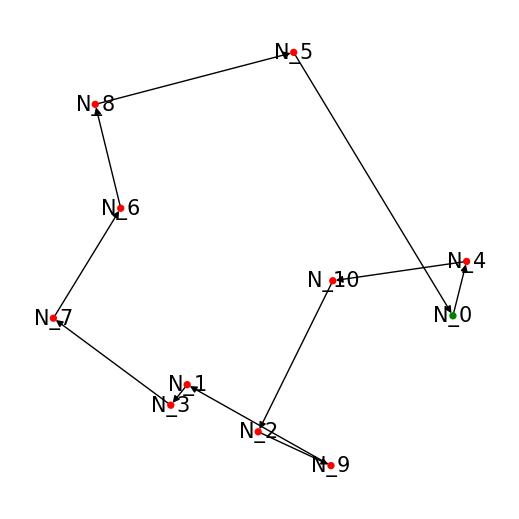

In [7]:
matriz_dst = calcular_matriz_dist(G)
demanda = simular_demanda_diaria(list(info_locales['r']), dist="n")
cap_tpte = cap_tpte
G = G
rutas_NN = nearest_neighbor(G, dist_matrix=matriz_dst, demands=demanda, capacity = cap_tpte)
graficar_ruta(rutas_NN[0], G)

In [8]:
calcular_largo_ruta(rutas_NN[0], matriz_dst)


1483.1524937291247

In [9]:
   # num_points = len(dist_matrix)
    # visited = np.zeros(num_points, dtype=bool)
    # routes = []

    # while np.sum(visited) < num_points:
    #     current_node = 0  # Start at node 0
    #     current_capacity = 0
    #     route = [current_node]
    #     visited[current_node] = True

    #     while current_capacity + demands[current_node] <= capacity:
    #         current = route[-1]
    #         nearest = None
    #         min_dist = float('inf')

    #         for neighbor in np.where(~visitados)[0]:
    #             if demands[neighbor] + current_capacity <= capacity and dist_matrix[current, neighbor] < min_dist:
    #                 nearest = neighbor
    #                 min_dist = dist_matrix[current, neighbor]

    #         if nearest is None:
    #             break

    #         route.append(nearest)
    #         visitados[nearest] = True
    #         current_capacity += demands[nearest]

    #     routes.append(route)

    # return routes

Mejora encontrada
Ruta anterior:  [0, 4, 10, 2, 9, 1, 3, 7, 6, 8, 5, 0]
Nueva ruta:  [0, 4, 10, 9, 2, 1, 3, 7, 6, 8, 5, 0]


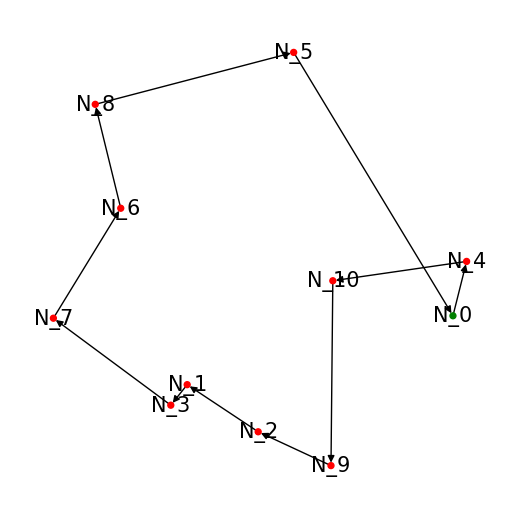

In [32]:
'''TWO OPT ALGORITHM FOR VRP'''

def two_opt(ruta_inicial, matriz_dst, iters):
     
    ruta_2opt = ruta_inicial.copy()

    for k in range(iters):
        i, j = np.random.randint(1, len(ruta_2opt) - 1, size=2)
        if j < i:
            i, j = j, i

        nueva_ruta = ruta_2opt.copy()
        nueva_ruta[i:j] = ruta_2opt[j - 1: i - 1: -1]
        
        if calcular_largo_ruta(nueva_ruta, matriz_dst) < calcular_largo_ruta(ruta_2opt, matriz_dst):
            print("Mejora encontrada")
            print("Ruta anterior: ", ruta_2opt)
            print("Nueva ruta: ", nueva_ruta)
            ruta_2opt = nueva_ruta
    
    return ruta_2opt

rutas_2opt = [two_opt(ruta, matriz_dst, 1000) for ruta in rutas_NN]
[0, 4, 10, 2, 9, 1, 3, 7, 6, 8, 5, 0]

graficar_ruta(rutas_2opt[0], G)

Ruta: [0, 4, 10, 2, 9, 1, 3, 7, 6, 8, 5, 0] en color: red
Agregando arco: 0 -> 4 en color: red
Agregando arco: 4 -> 10 en color: red
Agregando arco: 10 -> 2 en color: red
Agregando arco: 2 -> 9 en color: red
Agregando arco: 9 -> 1 en color: red
Agregando arco: 1 -> 3 en color: red
Agregando arco: 3 -> 7 en color: red
Agregando arco: 7 -> 6 en color: red
Agregando arco: 6 -> 8 en color: red
Agregando arco: 8 -> 5 en color: red
Agregando arco: 5 -> 0 en color: red
Ruta: [0, 4, 10, 9, 2, 1, 3, 7, 6, 8, 5, 0] en color: black
Agregando arco: 0 -> 4 en color: black
Agregando arco: 4 -> 10 en color: black
Agregando arco: 10 -> 9 en color: black
Agregando arco: 9 -> 2 en color: black
Agregando arco: 2 -> 1 en color: black
Agregando arco: 1 -> 3 en color: black
Agregando arco: 3 -> 7 en color: black
Agregando arco: 7 -> 6 en color: black
Agregando arco: 6 -> 8 en color: black
Agregando arco: 8 -> 5 en color: black
Agregando arco: 5 -> 0 en color: black
dict_values(['black', 'black', 'red', 'bla

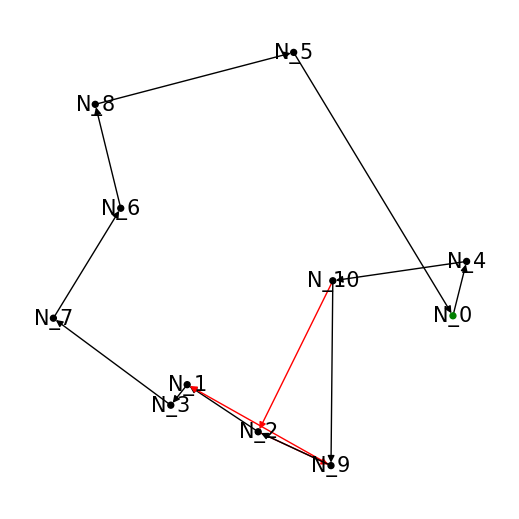

In [76]:
def graficar_rutas(rutas, G):
    colores = ['blue', 'green', 'orange', 'purple','black','red']
    grafo = nx.DiGraph()
    nodos = list(G.nodes())
    color_nodos = []
    color_edges = []
    for nodo in nodos:
        id_nodo = int(nodo[2:])
        grafo.add_node(nodo, pos=G.nodes()[nodo]['pos'])
        if id_nodo != 0:
            color_nodos.append('black')
        else:
            color_nodos.append('green')
    for ruta in rutas:
        color = colores[-1]
        colores.remove(color)
        print(f'Ruta: {ruta} en color: {color}')

        for i in range(len(ruta)-1):
            n1, n2 = ruta[i], ruta[i+1]
            grafo.add_edge(f'N_{n1}', f'N_{n2}', color=color)
            print(f'Agregando arco: {n1} -> {n2} en color: {color}')
            color_edges.append(color)

    plt.figure(figsize=(5,5))
    colors = nx.get_edge_attributes(grafo,'color').values()
    print(colors)
    pos=nx.get_node_attributes(G,'pos')
    # edges = grafo.edges()
    nx.draw(grafo, pos=pos, with_labels=True, node_size=18, font_size=15,  node_color = color_nodos, edge_color = colors)
    plt.show()
    

ruta_0 = [0, 4, 2, 10, 9, 3, 1, 8, 7, 6, 5, 0]
rutas = [ rutas_NN[0], rutas_2opt[0]]

graficar_rutas(rutas, G)

In [ ]:
    # best_routes = routes.copy()

    # for k in range(iters):
    #     selected_route_idx = np.random.randint(0, len(routes))
    #     selected_route = routes[selected_route_idx]

    #     i, j = np.random.randint(1, len(selected_route) - 1, size=2)
    #     if j < i:
    #         i, j = j, i

    #     new_route = selected_route.copy()
    #     new_route[i:j] = selected_route[j - 1: i - 1: -1]  # Reverse the path between i and j

    #     new_routes = routes.copy()
    #     new_routes[selected_route_idx] = new_route

    #     if calcular_largo_ruta(new_routes[selected_route_idx], dist_matrix) < calcular_largo_ruta(
    #             best_routes[selected_route_idx], dist_matrix
    #     ):
    #         best_routes = new_routes

    # return best_routes

In [ ]:
from alns import ALNS
from alns.accept import RecordToRecordTravel
from alns.select import RouletteWheel
from alns.stop import MaxRuntime

In [ ]:
class IRPState:
    '''
    Estado de solución del IRP
    '''
    def __init__(self,routes, unnasigned=None):
        self.routes = routes
        self.unnasigned = unnasigned if unnasigned is not None else []
    
    def copy(self):
        return IRPState(self.routes.copy(), self.unnasigned.copy())

    def objective(self):
        return sum([calcular_largo_ruta(ruta, matriz_dst) for ruta in self.routes])
    
    @property
    def cost(self):
        return self.objective()
    
    def find_route(self, node):
        for i, ruta in enumerate(self.routes):
            if node in ruta:
                return i
        return None

In [ ]:
degree_of_destruction = 0.05
nodes_to_destroy = int(degree_of_destruction * len(G.nodes))


def random_removal(state, random_state):
    destroyed = state.copy()

    for node in random_state.choice(destroyed.unnasigned, nodes_to_destroy, replace=False):
        destroyed.unnasigned.append(node)
        route = destroyed.find_route(node)
        route.remove(node)

    non_empty_routes = [ruta for ruta in destroyed.routes if len(ruta) > 0]
    
    destroyed.routes = non_empty_routes
    return destroyed


In [ ]:
# repair operators

def greedy_repair(state, random_state):
    repaired = state.copy()

    random_state.shuffle(repaired.unnasigned)

    while len(repaired.unnasigned) > 0:
        node = repaired.unnasigned.pop()
        route, idx = best_insert(node, repaired)
        if route is not None:
            route.insert(idx, node)
        else:
            repaired.routes.append([node])
    
    return repaired

def best_insert(node, state):

    best_cost, best_route, best_idx = float('inf'), None, None

    for route in state.routes:
        for i in range(len(route) + 1):
            if can_insert(node, route):
                cost = insertion_cost(node, route, i)

                if cost < best_cost:
                    best_cost = cost
                    best_route = route
                    best_idx = i
    
    return best_route, best_idx

def can_insert(node, route):
    total = sum([demanda[nodo] for nodo in route])
    return total + demanda[node] <= cap_tpte

def insertion_cost(node, route, idx):
    pred = 0 if idx == 0 else route[idx - 1]
    succ = 0 if idx == len(route) else route[idx]
    dist = matriz_dst[f'N_{pred}'][f'N_{node}'] + matriz_dst[f'N_{node}'][f'N_{succ}'] - matriz_dst[f'N_{pred}'][f'N_{succ}']
    return dist

In [ ]:
def neighbors(node):
    # ordenaremos los nodo por distancia al nodo actual
    return sorted(G.neighbors(node), key=lambda x: matriz_dst[f'N_{node}'][f'N_{x}'])

def nearest_neighbor_adapted():
    '''
    Adaptación del algoritmo Nearest Neighbor descrito anteriormente para que se utilice con la 
    clase IRPState
    '''
    routes = []
    nodes = list(G.nodes)
    while nodes:
        route = [0]
        route_demands = 0

        while nodes:
            current = route[-1]
            nearest = neighbors(current)[0]
            if route_demands + demanda[nearest] <= cap_tpte:
                route.append(nearest)
                route_demands += demanda[nearest]
                nodes.remove(nearest)
            else:
                break
        nodes = route[1:]
        routes.append(route)
    
    return IRPState(routes)


In [ ]:
T = 100 # periodos
V = 10 # vertices
def proactive_routing_only():
    '''
    pseudocode

    1: for t=0 to p-11 do
    2:  for i=1 to n do
    3:      Computean f-period forecastfor i based onpast
            demand observations.
    4:  end for
    5:  ApplytheALNS-basedheuristictothereduced f-period
    problem.
    6:  Implementtherouteobtainedforthe first period.
    7: end for
    '''
    for t in range(T):
        for i in range(1, V):
            d = simple_forecaster(x)
            pass

        alns = ALNS(np.random.RandomState(42), IRPState)
        alns.add_destroy_operator(random_removal)
        alns.add_repair_operator(greedy_repair)

        init = nearest_neighbor_adapted()
        select = RouletteWheel()
        accept = RecordToRecordTravel.autofit(init.onbjective(), 0.02, 0, 9000)
        stop = MaxRuntime(60)

        result = alns.iterate(init, select, accept, stop)
        solution = result.best_state
          
        # 5:  ApplytheALNS-basedheuristictothereduced f-period
        # problem.
        # 6:  Implementtherouteobtainedforthe first period.
        pass